In [122]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, minkowski
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor # knn 分类 回归
from sklearn.datasets import make_blobs # 数据集 聚类问题
from sklearn.model_selection import train_test_split # 划分数据集
from sklearn import datasets # 数据集
from sklearn.datasets import load_iris # 鸢尾花数据集
from sklearn.metrics import accuracy_score # 准确率计算
from sklearn.model_selection import GridSearchCV # 超参数调优 网格搜索交叉验证
from sklearn.preprocessing import StandardScaler # 数据预处理 标准化对象

import warnings
warnings.filterwarnings('ignore')  # 抑制所有警告

# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# KNN最<font color='red'>近</font>邻算法：近朱者赤近墨者黑

## 怎么想出来的：距离

距离决定一切  
K Nearest Neighbor  
透过现象理解本质

最早应用于分类  
回归 聚类都可以  
奥卡姆剃刀原理 Entities should not be multiplied unnecessarily

距离决定一切  
民主集中制

## 如何选择k值

<font color='#00BFFF'>偏听偏信：随便一个邻居都能决定你好坏</font>  
K太小导致过拟合overfit(裤子太紧)  
容易把噪声学进来

<font color='#00BFFF'>七大姑八大姨全问一遍(很多人不了解你)</font>  
K太大导致欠拟合underfit(裤子太大)  
决策效率低下

<font color='#00BFFF'>参详几个值得信任的</font>  
K不能太小 也不能太大  
Fit = 最优拟合  
超参数调优

## 距离的度量

特征空间中两点  
不同度量方法(计算标准：汽车、飞机、电话)

欧几里得距离Euclidean $y=\sqrt{\sum_{i=1}^{n}{\left| x_{i}-y_{i} \right|^{2}}}$  
曼哈顿距离Manhattan $y=\sum_{i=1}^{n}{\left| x_{i}-y_{i} \right|}$  
闵可夫斯基距离Minkowski $y=\left( \sum_{i=1}^{n}{\left| x_{i}-y_{i} \right|^{p}} \right)^{\frac{1}{p}}$  

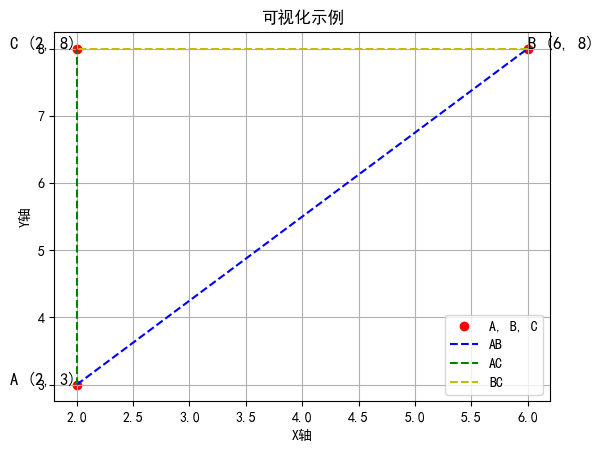

In [2]:
# 创建点A和B
A = np.array([2, 3])
B = np.array([6, 8])

# 创建三角形ABC
C = np.array([2, 8])

# 绘制点A、B和C
plt.scatter([A[0], B[0], C[0]], [A[1], B[1], C[1]], c='red', marker='o', label='A, B, C')

# 添加标签
plt.text(A[0], A[1], 'A (2, 3)', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B (6, 8)', fontsize=12, ha='left')
plt.text(C[0], C[1], 'C (2, 8)', fontsize=12, ha='right')

# 连接点A、B和C
plt.plot([A[0], B[0]], [A[1], B[1]], 'b--', label='AB')
plt.plot([A[0], C[0]], [A[1], C[1]], 'g--', label='AC')
plt.plot([B[0], C[0]], [B[1], C[1]], 'y--', label='BC')

plt.legend()

plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.title('可视化示例')

plt.grid()
plt.show()

In [3]:
manhattan_distance = np.abs(A[0] - B[0]) + np.abs(A[1] - B[1])
print(f'曼哈顿距离 (d_AB)：{manhattan_distance:.2f}')

曼哈顿距离 (d_AB)：9.00


In [4]:
euclidean_distance = np.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2)
print(f'欧氏距离 (d_AB)：{euclidean_distance:.2f}')

欧氏距离 (d_AB)：6.40


In [5]:
p1_distance = np.abs(A[0] - B[0]) + np.abs(A[1] - B[1])  # p = 1，曼哈顿距离
p2_distance = np.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2)  # p = 2，欧氏距离
print(f'p = 1 时的闵可夫斯基距离 (d_AB)：{p1_distance:.2f}')
print(f'p = 2 时的闵可夫斯基距离 (d_AB)：{p2_distance:.2f}')

p = 1 时的闵可夫斯基距离 (d_AB)：9.00
p = 2 时的闵可夫斯基距离 (d_AB)：6.40


## 特征划归一的必要：量纲

# 分类任务的代码实现

## 数据准备

In [6]:
# 样本特征
data_X = [
    [1.3, 6],
    [3.5, 5],
    [4.2, 2],
    [5, 3.3],
    [2, 9],
    [5, 7.5],
    [7.2, 4 ],
    [8.1, 8],
    [9, 2.5]
]
# 样本标记
data_label = [0,0,0,0,1,1,1,1,1]

In [7]:
# 将两个特征+一个标签的数据转为df
def to_df_from_two_one(x,l):
    df = pd.DataFrame(x,columns=['特征1','特征2'])
    df['label'] = l
    return df

In [8]:
df = to_df_from_two_one(data_X, data_label)
df

,特征1,特征2,label
0,1.3,6.0,0
1,3.5,5.0,0
2,4.2,2.0,0
3,5.0,3.3,0
4,2.0,9.0,1
5,5.0,7.5,1
6,7.2,4.0,1
7,8.1,8.0,1
8,9.0,2.5,1


In [9]:
# 训练集
X_train = np.array(data_X)
y_train = np.array(data_label)

In [10]:
print(X_train)
print(y_train)

[[1.3 6. ]
 [3.5 5. ]
 [4.2 2. ]
 [5.  3.3]
 [2.  9. ]
 [5.  7.5]
 [7.2 4. ]
 [8.1 8. ]
 [9.  2.5]]
[0 0 0 0 1 1 1 1 1]


In [11]:
print(y_train==0)
print(X_train[y_train==0])

[ True  True  True  True False False False False False]
[[1.3 6. ]
 [3.5 5. ]
 [4.2 2. ]
 [5.  3.3]]


In [12]:
print(X_train[y_train==0,0]) # 从4行数据中 选出第一列  x轴坐标数据
print(X_train[y_train==0,1]) # 从4行数据中 选出第二列  y轴坐标数据

[1.3 3.5 4.2 5. ]
[6.  5.  2.  3.3]


## 散点图绘制

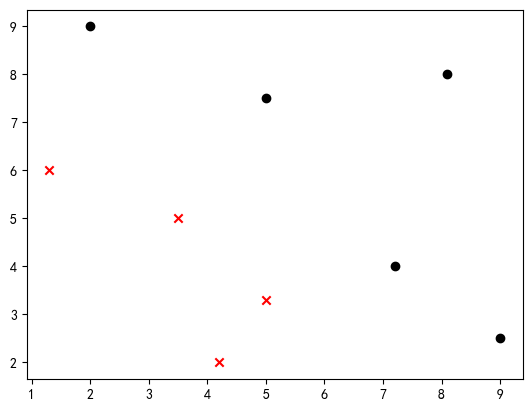

In [13]:
plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], color='red', marker='x') # 标签为0的 x
plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], color='black', marker='o') # 标签为1 o
plt.show()

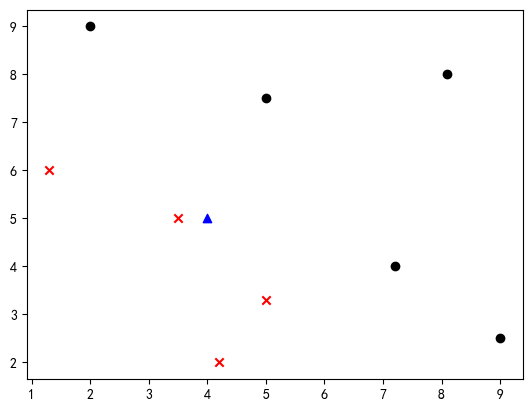

In [14]:
# 新的样本点  需要预测
data_new = np.array([4,5])

plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], color='red', marker='x') # 标签为0的 x
plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], color='black', marker='o') # 标签为1 o
plt.scatter(data_new[0], data_new[1], color='b', marker='^') # 新样本 ^
plt.show()

## KNN预测：计算新样本点与已知样本点的距离

In [15]:
# data - data_new 两个向量相减 对应元素相减
for data in X_train:
    print(np.sqrt(np.sum((data - data_new)**2))) # data - data_new 两向量相减 对应元素相减

2.879236009777594
0.5
3.006659275674582
1.9723082923316022
4.47213595499958
2.692582403567252
3.3526109228480423
5.080354318352215
5.5901699437494745


In [16]:
distances = [np.sqrt(np.sum((data - data_new)**2)) for data in X_train]
distances

[2.879236009777594,
 0.5,
 3.006659275674582,
 1.9723082923316022,
 4.47213595499958,
 2.692582403567252,
 3.3526109228480423,
 5.080354318352215,
 5.5901699437494745]

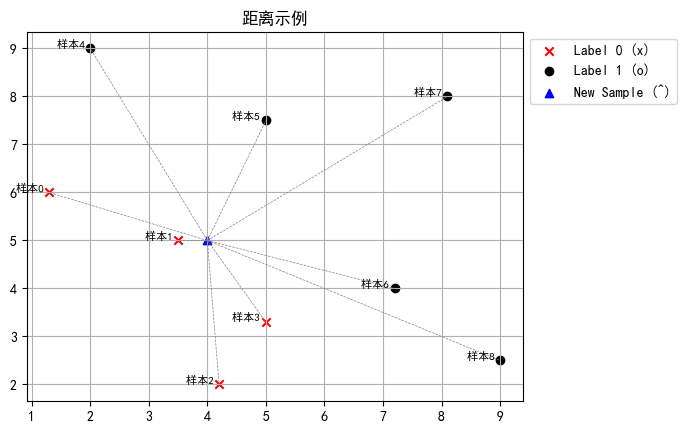

In [17]:
# 绘制散点图
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', marker='x', label='Label 0 (x)')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='black', marker='o', label='Label 1 (o)')
plt.scatter(data_new[0], data_new[1], color='blue', marker='^', label='New Sample (^)')

# 实现data_new与X_train中每个点的连线，并添加标注
for i, point in enumerate(X_train):
    plt.plot([data_new[0], point[0]], [data_new[1], point[1]], '--', color='gray', linewidth=0.5)
    plt.text(point[0], point[1], f'样本{i} ', fontsize=8, ha='right', va='bottom')
#     plt.text(point[0], point[1], f'({point[0]:.1f}, {point[1]:.1f})', fontsize=8, ha='right', va='bottom')
    
plt.legend(bbox_to_anchor=(1,1))
plt.title('距离示例')
plt.grid()
plt.show()

## KNN预测：按距离排序

In [18]:
np.sort(distances)

array([0.5       , 1.97230829, 2.6925824 , 2.87923601, 3.00665928,
       3.35261092, 4.47213595, 5.08035432, 5.59016994])

In [19]:
sort_index = np.argsort(distances)
sort_index

array([1, 3, 5, 0, 2, 6, 4, 7, 8], dtype=int64)

## KNN预测：确定k值

In [20]:
k = 5 # 不妨

## KNN预测：距离最近的k个点投票

In [21]:
first_k = [y_train[i] for i in sort_index[:k]] # 选前k个 距离最近的  类别标签(结果)
first_k

[0, 0, 1, 0, 0]

In [22]:
Counter(first_k) # 计数  返回字典 类别为0的4个 类别为1的1个

Counter({0: 4, 1: 1})

In [23]:
Counter(first_k).most_common() # 返回元组列表 类别为0的4个 类别为1的1个

[(0, 4), (1, 1)]

In [24]:
Counter(first_k).most_common(1) # 返回元组列表  出现次数最多的

[(0, 4)]

In [25]:
predict_y = Counter(first_k).most_common(1)[0][0] # 取列表的第一个元组 取元组的第一个元素
predict_y

0

## scikit-learn中的KNN算法

In [26]:
kNN_classifier = KNeighborsClassifier(n_neighbors=5) # 面向对象封装 设置k值
kNN_classifier.fit(X_train, y_train) # 实例 调用fit方法  传入数据

KNeighborsClassifier()

In [27]:
data_new.reshape(1,-1) # 传入要预测是新数据样本  传参要求二维数组
predict_y = kNN_classifier.predict(data_new.reshape(1,-1))
predict_y

array([0])

# 这么干对不对：数据集的划分(训练集8 测试集2)

训练/授课、测试/考试 - 不要死记硬背  
1 评价模型性能  
2 防止过拟合  
3 提升泛化能力

## 数据集准备

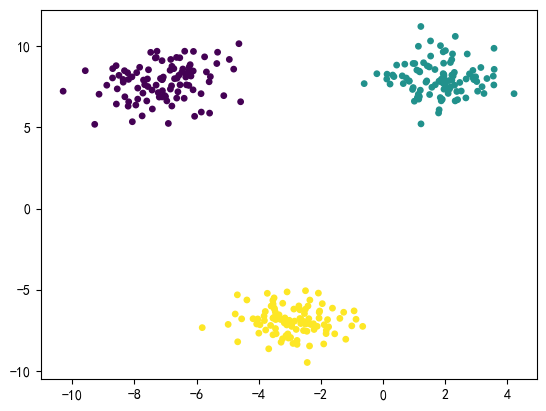

In [28]:
x, label = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=1, 
                      center_box=(-10,10), random_state=233, return_centers=False)
plt.scatter(x[:,0], x[:,1], c=label, s=15)
plt.show()

## 手动划分数据集

In [29]:
# 洗牌法一shuffle
index = np.arange(20)
print(index)
np.random.shuffle(index) # 随机打乱顺序
print(index)

# 洗牌法二permutation
np.random.permutation(20) # 生成一个包含0到19的整数（20个整数）的随机排列 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[19  8 16  6  0 14 15  1  4  9 12 13  5 11 17 10  2  3 18  7]


array([14,  5,  9, 15, 13,  8, 18,  4,  0,  2, 17, 11, 19,  3,  1, 10,  7,
        6, 16, 12])

In [30]:
np.random.seed(233) # 随机种子
shuffle = np.random.permutation(len(x)) # 生成一个随机的索引数组，通常用于对数据集或数组进行随机洗牌
print(shuffle)
print(shuffle.shape)

[ 23  86 204 287 206 170 234  94 146 180 263  22   3 264 194 290 229 177
 208 202  10 188 262 120 148 121  98 160 267 136 294   2  34 142 271 133
 127  12  29  49 112 218  36  57  45  11  25 151 212 289 157  19 275 176
 144  82 161  77  51 152 135  16  65 189 298 279  37 187  44 210 178 165
   6 162  66  32 198  43 108 211  67 119 284  90  89  56 217 158 228 248
 191  47 296 123 181 200  40  87 232  97 113 122 220 153 173  68  99  61
 273 269 281 209   4 110 259  95 205 288   8 283 231 291 171 111 242 216
 285  54 100  38 185 235 174 201 107 223 222 196 268 114 147 166  85  39
  58 256 258  74 251  15 150 137  70  91  52  14 169  21 184 207 238 128
 219 125 293 134  27 265  96 270  18 109 126 203  88 249  92 213  60 227
   5  59   9 138 236 280 124 199 225 149 145 246 192 102  48  73  20  31
  63 237  78  62 233 118 277  28  50  64 117 197 140   7 105 252  71 190
  76 103  93 183  72   0 278  79 172 214 182 292 139 260  30 195  13 244
 240 297 257 245 143 186 243 266 286 168 179  81 21

In [31]:
train_size = 0.7 # 训练集占比
train_index = shuffle[:int(len(x)*train_size)] # 取整 int
test_index = shuffle[int(len(x)*train_size):]
print(train_index.shape)
print(test_index.shape)

(210,)
(90,)


In [32]:
x[train_index].shape, label[train_index].shape # 根据条件筛选x 训练集 

((210, 2), (210,))

In [33]:
x[test_index].shape, label[test_index].shape # 根据条件筛选x label  测试集 

((90, 2), (90,))

In [34]:
# 封装成方法
def my_train_test_split(x, label,train_size=0.7,random_state=None):
    if random_state:
        np.random.seed(random_state)
    shuffle = np.random.permutation(len(x))
    train_index = shuffle[:int(len(x)*train_size)]
    test_index = shuffle[int(len(x)*train_size):]
    return x[train_index], x[test_index], label[train_index], label[test_index]

In [35]:
x_train, x_test, label_train, label_test = my_train_test_split(x, label, train_size=0.7, random_state=233)
x_train.shape, x_test.shape, label_train.shape, label_test.shape 

((210, 2), (90, 2), (210,), (90,))

In [36]:
df_train = to_df_from_two_one(x_train, label_train)
df_train

,特征1,特征2,label
0,-4.380421,-5.624301,2
1,-1.824430,-7.487818,2
2,-7.602587,6.620215,0
3,-2.639383,-6.797956,2
4,1.962590,7.343619,1
...,...,...,...
205,-8.320376,8.483773,0
206,1.937106,8.301027,1
207,-5.855636,7.068262,0
208,3.045403,7.219806,1


In [37]:
df_test = to_df_from_two_one(x_test, label_test)
df_test

,特征1,特征2,label
0,-6.851545,8.509050,0
1,1.951112,8.942094,1
2,1.424867,8.779673,1
3,-3.996049,-7.667442,2
4,-7.327162,9.266263,0
...,...,...,...
85,-3.345886,-6.537964,2
86,-6.708119,7.991813,0
87,-5.323802,9.619133,0
88,1.500065,7.015954,1


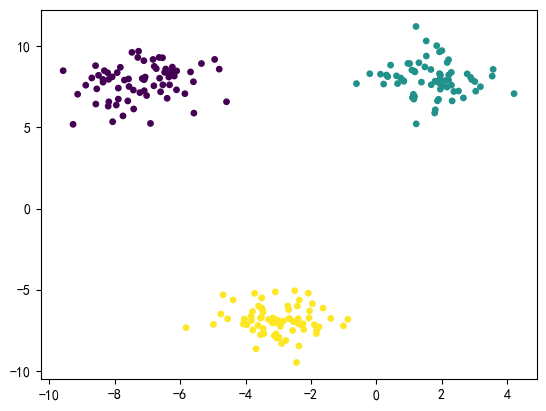

In [38]:
plt.scatter(x_train[:,0], x_train[:,1], c=label_train, s=15)
plt.show()

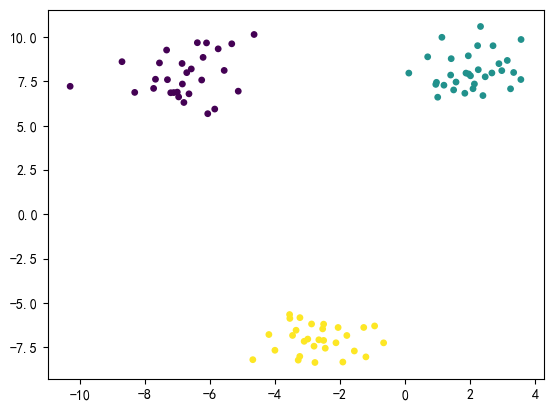

In [39]:
plt.scatter(x_test[:,0], x_test[:,1], c=label_test, s=15)
plt.show()

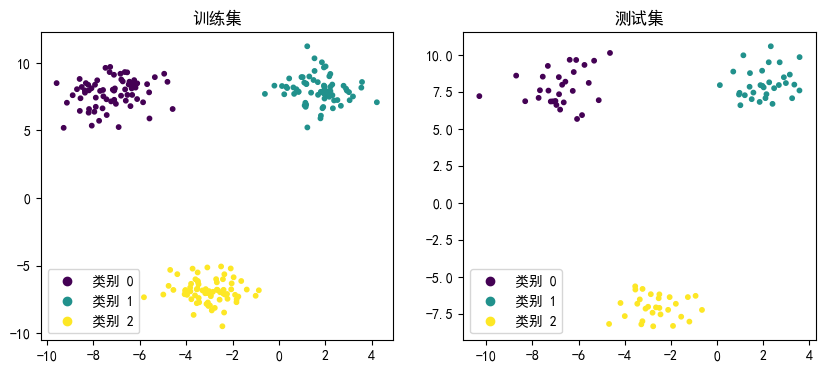

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

scatter_train = axes[0].scatter(x_train[:, 0], x_train[:, 1], c=label_train, cmap='viridis', s=10, label='类别')
axes[0].set_title('训练集')
axes[0].legend(handles=scatter_train.legend_elements()[0], labels=['类别 0', '类别 1', '类别 2'])

scatter_test = axes[1].scatter(x_test[:, 0], x_test[:, 1], c=label_test, cmap='viridis', s=10, label='类别')
axes[1].set_title('测试集')
axes[1].legend(handles=scatter_test.legend_elements()[0], labels=['类别 0', '类别 1', '类别 2'])

plt.show()

## sklearn调库划分数据集

In [41]:
x_train,x_test,label_train,label_test = train_test_split(x,label,train_size=0.7,random_state=233)
x_train.shape, x_test.shape, label_train.shape, label_test.shape

((210, 2), (90, 2), (210,), (90,))

In [42]:
to_df_from_two_one(x_train,label_train)

,特征1,特征2,label
0,-5.348754,8.923276,0
1,-9.277840,5.182120,0
2,-8.219142,8.356371,0
3,-6.107564,8.465348,0
4,0.750927,8.032041,1
...,...,...,...
205,-3.345886,-6.537964,2
206,-6.708119,7.991813,0
207,-5.323802,9.619133,0
208,1.500065,7.015954,1


In [43]:
to_df_from_two_one(x_test, label_test)

,特征1,特征2,label
0,-4.380421,-5.624301,2
1,-1.824430,-7.487818,2
2,-7.602587,6.620215,0
3,-2.639383,-6.797956,2
4,1.962590,7.343619,1
...,...,...,...
85,-3.464968,-6.372257,2
86,-2.765550,-8.113904,2
87,0.620366,8.164757,1
88,0.352503,8.119305,1


In [44]:
Counter(label_test)

Counter({2: 34, 0: 25, 1: 31})

In [45]:
# 为了确保在训练集和测试集中各类别的样本比例与原始数据集中的比例相似，可以使用 stratify 参数
x_train,x_test,label_train,label_test = train_test_split(x,label,train_size=0.7,random_state=233, stratify=label) 
Counter(label_test)

Counter({2: 30, 0: 30, 1: 30})

# 这么干对不对：模型评价accuracy

In [46]:
iris = datasets.load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [47]:
# 将两个特征+一个标签的数据转为df
def to_df_from_four_one(x,l):
    df = pd.DataFrame(x,columns=['特征1','特征2', '特征3','特征4'])
    df['label'] = l
    return df

In [48]:
iris = datasets.load_iris()
data, target = iris.data, iris.target # 字典形式
to_df_from_four_one(data, target)

,特征1,特征2,特征3,特征4,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [49]:
iris = datasets.load_iris()
data = iris.data  # 特征数据
target = iris.target  # 目标数据

df = pd.DataFrame(data, columns=iris.feature_names)
df['target'] = target

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [50]:
iris.keys() # 字典形式

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [51]:
X = iris.data
X.shape

(150, 4)

In [52]:
label = iris.target
label.shape

(150,)

In [53]:
print(iris.feature_names)
print(iris.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


## 自己实现拆分数据集

In [54]:
# 随机化 需要打乱洗牌(对索引值操作)
shuffle_index = np.random.permutation(len(label))
shuffle_index

array([ 23,   7, 127,  81, 149,  54,   6,  62,  52, 144,  38,  21, 141,
       128, 138,  33,  84,  50,  11,   9,  41, 134,  86,  22,  12,  95,
       115,  34,  36,  27,  18,  16,  29,  42, 105,  10,  90, 147, 121,
       146,   5, 107, 117,  80,  89, 112,  61,   1, 123,  91,  40,  57,
        14,  76,  63, 148, 120, 131, 113, 106,  17, 102, 142,  96,  87,
        68,  88,  85,   2,  66,   4, 145, 129,  44,  67,  83,  51,  94,
       100,  75, 122,  25, 101,  92,  93,  97,  24,  79,  32,  74, 135,
         3,  30,   8, 104,  28, 143, 139,  53,  47,  19, 133,  73,  55,
        35, 108,  77,  99,  71,  58,  45, 109,  39, 118,  37, 140,  60,
        46,  82,  31,  26, 103, 124, 110,  69, 114, 116,  48, 137, 125,
        59,  65,  20, 111,  78,  70,  49,  98, 126, 130, 119,  15,  72,
         0,  56,  13, 132, 136,  64,  43])

In [55]:
train_ratio = 0.8 # 测试集占比
train_size = int(len(X)*train_ratio) # 训练集个数
print(train_size)

train_index = shuffle_index[:train_size] # 训练集索引
test_index = shuffle_index[train_size:] # 测试集索引

# 根据索引条件筛选
X_train = X[train_index]
label_train = label[train_index]

X_test = X[test_index]
label_test = label[test_index]

# 查看
print(X_train.shape)
print(label_train.shape)

print(X_test.shape)
print(label_test.shape)

120
(120, 4)
(120,)
(30, 4)
(30,)


## 调库实现拆分数据集

In [56]:
# 调库实现数据集的划分  输入是X和label
X_train,X_test,label_train,label_test = train_test_split(X,label,train_size=0.7,random_state=374)

In [57]:
to_df_from_four_one(X_train,label_train).tail()

,特征1,特征2,特征3,特征4,label
100,6.2,3.4,5.4,2.3,2
101,5.0,3.5,1.3,0.3,0
102,5.4,3.0,4.5,1.5,1
103,5.1,3.4,1.5,0.2,0
104,5.4,3.4,1.5,0.4,0


In [58]:
to_df_from_four_one(X_test,label_test).tail()

,特征1,特征2,特征3,特征4,label
40,5.1,3.7,1.5,0.4,0
41,6.5,3.0,5.2,2.0,2
42,5.1,3.5,1.4,0.3,0
43,5.1,3.5,1.4,0.2,0
44,6.6,2.9,4.6,1.3,1


## KNN预测

In [59]:
knn_classifier = KNeighborsClassifier(n_neighbors=5) # knn
knn_classifier.fit(X_train, label_train) # 实例 调用fit方法  传入数据训练

KNeighborsClassifier()

In [60]:
knn_classifier.score(X_test,label_test) # 也可以直接查看准确度

0.9111111111111111

In [61]:
# 新样本预测
label_predict = knn_classifier.predict(X_test)
label_predict

array([0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 2, 1, 1, 0, 1, 2, 2,
       2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 0, 0, 2, 1, 2, 2, 0, 2, 0, 0,
       1])

## accutacy评价

In [62]:
label_test

array([0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1,
       1, 2, 2, 1, 1, 1, 0, 1, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0,
       1])

In [63]:
label_predict == label_test # 预测正确的情况

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True])

In [64]:
np.sum(label_predict == label_test) # 预测对的个数

41

In [65]:
accutacy = np.sum(label_predict==label_test) / len(label_test) # 自己写 准确率计算
accutacy

0.9111111111111111

In [66]:
accuracy_score(label_test,label_predict) # 调库 准确率计算

0.9111111111111111

# 选哪个K最好：超参数Hyperparameter的调优问题

人为设置的参数  
(人)经验值  
(机器)参数搜索 

In [67]:
# 加载数据集
iris = load_iris()
x, label = iris.data, iris.target
x.shape, label.shape

((150, 4), (150,))

In [68]:
# 划分数据集
x_train,x_test,label_train,label_test = train_test_split(x,label,train_size=0.7,random_state=374,stratify=label)
x_train.shape,x_test.shape,label_train.shape,label_test.shape

((105, 4), (45, 4), (105,), (45,))

In [69]:
# knn超参数：选取最近点的个数k、选取点的权重weight(分类表决 加权分类表决)、闵可夫斯基距离的p
neigh = KNeighborsClassifier(n_neighbors=3,weights='distance',p=2)
neigh.fit(x_train,label_train) # 训练

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [70]:
# 在测试集上的准确率评价
neigh.score(x_test,label_test)

0.9555555555555556

## 超参数初始化

In [71]:
best_score = -1
best_n = -1 # n_neighbors最近点的个数
best_weight = '' # 选取点的权重weight(分类表决 加权分类表决)  uniform相同权重  distance距离越近权重越大
best_p = -1 # 闵可夫斯基距离的p

## 自己一个一个去试

In [72]:
# 网页搜索：遍历所有超参数的可能性 选择准确率最高的
for n in range(1,20):
    for weight in ['uniform','distance']:
        for p in range(1,7):
            neigh = KNeighborsClassifier(n_neighbors=n,weights=weight,p=p)
            neigh.fit(x_train,label_train)
            score = neigh.score(x_test,label_test)
            
            if score > best_score:
                best_score = score
                best_n = n
                best_weight = weight
                best_p = p

print(f'n_neighbors: {best_n}')
print(f'weights: {best_weight}')
print(f'p: {best_p}')
print(f'score: {best_score}')

n_neighbors: 3
weights: uniform
p: 3
score: 0.9777777777777777


## 调库实现sklearn超参数搜索

In [73]:
# 参数字典
params = {'n_neighbors': [n for n in range(1,20)],
         'weights': ['uniform','distance'],
         'p': [p for p in range(1,7)]}

In [74]:
# 网页搜索
grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, n_jobs=-1) # n_jobs GPU并行计算(不同参数间没什么关系)
grid.fit(x_train, label_train) # 训练

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'p': [1, 2, 3, 4, 5, 6],
                         'weights': ['uniform', 'distance']})

In [75]:
# 准确率计算不同导致的
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.980952380952381


In [76]:
# 选取最优的knn对象
grid.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [77]:
grid.best_estimator_.predict(x_test) # 测试

array([0, 2, 0, 2, 1, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 1,
       2, 2, 0, 0, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 2,
       0])

In [78]:
grid.best_estimator_.score(x_test,label_test) # 准确率

0.9555555555555556

# 特征维度的影响：特征归一化feature_scaling

身高的影响微乎其微、体总的影响很大  
1.9m比90斤大？<font color='red'>不同的指标不具备可比性</font>  
1.9m比90%的人都要高、90斤比40%的人要瘦

特征归一化：消除数据特征量纲的影响 使得不同指标具备一定程度上的可比性 反映特征的重要程度

【不同方式的特征归一化】 

最大最小值归一化min_max_scaling：$x_{norm}=\frac{x-x_{min}}{x_{max}\, -\, x_{min}} $  
最终结果是0到1的数，实现对原始数据的等比缩放  
受极端值的影响较大(失真)

零均值归一化zero_score_normalization：$x_{norm}=\frac{x-\mu}{\sigma}$

## 自己实现最大最小值归一化

In [79]:
iris = datasets.load_iris()
X = iris.data # 对特征值进行归一化
label = iris.target
X[:5] # 预览前5行数据

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [80]:
max_col1 = np.max(X[:,0]) # 第一列数据的最大值
min_col1 = np.min(X[:,0]) # 第一列数据的最小值
print(max_col1)
print(min_col1)

7.9
4.3


In [81]:
X[:,0] = (X[:,0] - min_col1) / (max_col1 - min_col1) # 第一列 特征归一化  nparr向量广播机制
X[:5,0] # 预览第一列的归一化结果

array([0.22222222, 0.16666667, 0.11111111, 0.08333333, 0.19444444])

In [82]:
X[:,1] = (X[:,1] - np.min(X[:,1])) / (np.max(X[:,1]) - np.min(X[:,1])) # 第二列 特征归一化
X[:,2] = (X[:,2] - np.min(X[:,2])) / (np.max(X[:,2]) - np.min(X[:,2])) # 第三列 特征归一化
X[:,3] = (X[:,3] - np.min(X[:,3])) / (np.max(X[:,3]) - np.min(X[:,3])) # 第四列 特征归一化
X[:5] # 预览前5行数据 归一化结果

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667]])

## 自己实现零均值归一化

In [83]:
iris = datasets.load_iris()
X = iris.data # 对特征值进行归一化
label = iris.target
X[:5] # 预览 前5行

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [84]:
mean_col1 = np.mean(X[:,0]) # 第一列 均值
std_col1 = np.std(X[:,0]) # 第一列 标准差
print(mean_col1)
print(std_col1)

5.843333333333334
0.8253012917851409


In [85]:
X[:,0] = (X[:,0] - np.mean(X[:,0])) / np.std(X[:,0]) # 第一列 特征归一化
X[:5,0] # 预览第一列

array([-0.90068117, -1.14301691, -1.38535265, -1.50652052, -1.02184904])

In [86]:
# 处理后的均值方差
print(np.mean(X[:,0])) # 几乎为0
print(np.std(X[:,0])) # 为1

-4.736951571734001e-16
1.0


In [87]:
X[:,1] = (X[:,1] - np.mean(X[:,1])) / np.std(X[:,1]) # 第二列 特征归一化
X[:,2] = (X[:,2] - np.mean(X[:,2])) / np.std(X[:,2]) # 第三列 特征归一化
X[:,3] = (X[:,3] - np.mean(X[:,3])) / np.std(X[:,3]) # 第四列 特征归一化
X[:5] # 预览前5行数据 归一化结果

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

## 调库scikit-learn实现零均值归一化standard_scaler

In [88]:
iris = datasets.load_iris()
X = iris.data
label = iris.target
X[:5] # 预览 前5行

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [89]:
standard_scaler = StandardScaler() # 标准化对象
standard_scaler.fit(X)

StandardScaler()

In [90]:
print(standard_scaler.mean_) # 每个特征的均值
print(standard_scaler.scale_) # 每个特征的标准差 

[5.84333333 3.05733333 3.758      1.19933333]
[0.82530129 0.43441097 1.75940407 0.75969263]


In [91]:
X = standard_scaler.transform(X) # 将原始数据标准化 零均值归一化
X[:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

## 再走一遍流程

测试集的归一化  
train_mean、train_standard <font color='red'>v</font>  
test_mean、test_standard <font color='red'>x 测试集模拟的是真实的环境 真实环境很难得到均值和方差</font>

In [92]:
# 划分数据集
X_train,X_test,label_train,label_test = train_test_split(X,label,train_size=0.7,random_state=666)

In [93]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)

StandardScaler()

In [94]:
print(standard_scaler.mean_) # 每个特征的均值
print(standard_scaler.scale_) # 每个特征的标准差 

[-0.03288842  0.06971673 -0.05028759 -0.05553625]
[0.97840604 1.00801867 1.00128321 0.99336226]


In [95]:
X_train_standard = standard_scaler.transform(X_train) # 将原始数据标准化
X_test_standard = standard_scaler.transform(X_test) # 将原始数据标准化

In [96]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_standard,label_train) # 训练

KNeighborsClassifier()

In [97]:
knn_classifier.score(X_test_standard, label_test)

0.9777777777777777

# 回归任务的代码实现

求均值：周围的数据对候选预测点影响力的叠加  

In [111]:
data_X = [
    [1.3, 6],
    [3.5, 5],
    [4.2, 2],
    [5, 3.3],
    [2, 9],
    [5, 7.5],
    [7.2, 4 ],
    [8.1, 8],
    [9, 2.5]
]
data_label = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7] # 回归预测 数值类型

X_train = np.array(data_X)
label_train = np.array(data_label)

data_new = np.array([4,5])

In [120]:
to_df_from_two_one(X_train,label_train)

,特征1,特征2,label
0,1.3,6.0,0.1
1,3.5,5.0,0.3
2,4.2,2.0,0.5
3,5.0,3.3,0.7
4,2.0,9.0,0.9
5,5.0,7.5,1.1
6,7.2,4.0,1.3
7,8.1,8.0,1.5
8,9.0,2.5,1.7


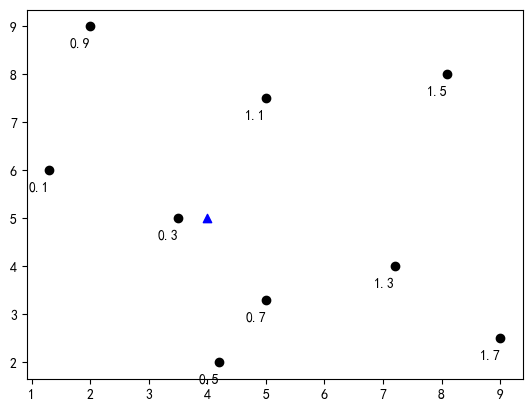

In [112]:
plt.scatter(X_train[:,0],X_train[:,1],color='black')
plt.scatter(data_new[0], data_new[1],color='b', marker='^')
for i in range(len(label_train)):
    plt.annotate(label_train[i], xy=X_train[i], xytext=(-15,-15), textcoords='offset points') # annotate label

plt.show()

In [113]:
distances = [np.sqrt(np.sum((data - data_new)**2)) for data in X_train]
sort_index = np.argsort(distances)
print(distances)
print(sort_index)

[2.879236009777594, 0.5, 3.006659275674582, 1.9723082923316022, 4.47213595499958, 2.692582403567252, 3.3526109228480423, 5.080354318352215, 5.5901699437494745]
[1 3 5 0 2 6 4 7 8]


In [114]:
k = 5
first_k =  [label_train[i] for i in sort_index[:k]]

In [115]:
Counter(first_k).most_common(1)
predict_y = Counter(first_k).most_common(1)[0][0]
predict_y

0.3

In [116]:
k = 5
first_k =  [label_train[i] for i in sort_index[:k]]
np.mean(first_k) # 核心 计算均值

0.54

## Scikit learn 实现KNN回归 

In [123]:
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, label_train) # 训练

KNeighborsRegressor()

In [124]:
predict_label = knn_reg.predict(data_new.reshape(1,-1))
predict_label

array([0.54])